In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

import sys
sys.path.append('../')
# from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms, calc_BICint, calc_LME
from pyEM import plotting
import rw_models

In [18]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy.stats import norm
from copy import deepcopy
from pyEM.math import compGauss_ms, calc_LME

class HierarchicalEMModel:
    def __init__(self, objfunc, param_names, convergence_type='NPL', convergence_method='sum'):
        self.objfunc = objfunc
        self.param_names = param_names
        self.convergence_type = convergence_type
        self.convergence_method = convergence_method
        self.posterior = {
            'mu': 0.1 * np.random.randn(len(param_names), 1),
            'sigma': np.full((len(param_names),), 100)
        }

    def expectation_step(self, objfunc_input, prior, maxit=None, **kwargs):
        nparams = len(self.param_names)
        if maxit is None:
            maxit = 0

        opts = {'gtol': 1e-3, 'eps': 0.0001}

        # Fit model using random initial parameter values
        fval = 1e6
        ex = False
        tmp = 0
        while not ex:
            q = 0.1 * np.random.randn(nparams)

            if isinstance(objfunc_input, pd.DataFrame):
                result = minimize(self.objfunc, x0=q, args=(objfunc_input, prior), method='BFGS', options=opts)
            else:
                result = minimize(self.objfunc, x0=q, args=(*objfunc_input, prior), method='BFGS', options=opts)

            q_est = result.x
            fval = result.fun
            ex = result.success

            if not ex:
                tmp += 1
                if tmp > maxit:
                    ex = True

        inv_h = result.hess_inv
        nl_prior = -prior['logpdf'](q_est)

        return q_est, inv_h, fval, nl_prior

    def EMfit(self, all_data, verbose=1, mstep_maxit=800, estep_maxit=None):
        nparams = len(self.param_names)
        nsubjects = len(all_data)

        # Initialize transient variables
        nextbreak = 0
        NPL_old = -np.inf
        NPL_list = []

        for iiter in range(mstep_maxit):
            # Initialize subject-level parameter matrices
            m = np.zeros((nparams, nsubjects))
            inv_h = np.zeros((nparams, nparams, nsubjects))

            # Set up prior
            prior = {
                'mu': deepcopy(self.posterior['mu']),
                'sigma': deepcopy(self.posterior['sigma']),
                'logpdf': lambda x: np.sum(norm.logpdf(x, self.posterior['mu'], np.sqrt(self.posterior['sigma'])))
            }

            # Perform expectation step for all subjects in parallel
            results = Parallel(n_jobs=-1)(
                delayed(self.expectation_step)(all_data[subj_idx], prior, estep_maxit)
                for subj_idx in range(nsubjects)
            )

            this_NPL = np.zeros((nsubjects, 1))
            for subj_idx, (q_est, hess_mat, fval, nl_prior) in enumerate(results):
                m[:, subj_idx] = deepcopy(q_est)
                inv_h[:, :, subj_idx] = deepcopy(hess_mat)
                this_NPL[subj_idx] = deepcopy(fval)

            # Maximization step: update group-level parameters
            curmu, cursigma, flagcov, _ = compGauss_ms(m, inv_h)
            if flagcov == 1:
                self.posterior['mu'] = deepcopy(curmu)
                self.posterior['sigma'] = deepcopy(cursigma)

            # Convergence check
            NPL_convergence_value = self.hierarchical_convergence(this_NPL, method=self.convergence_method)
            if self.convergence_type == 'NPL':
                NPL_list.append(NPL_convergence_value)
                if verbose >= 1:
                    print(f'{NPL_convergence_value:.3f} ({iiter:03d})', end=', ')
                if abs(NPL_convergence_value - NPL_old) < 0.001 and flagcov == 1:
                    print(" -- CONVERGED!!!!!")
                    convergence = True
                    break
                NPL_old = NPL_convergence_value

            if iiter == (mstep_maxit - 1):
                print('-MAXIMUM NUMBER OF ITERATIONS REACHED\n')
                convergence = False

        return {
            'm': m,
            'inv_h': inv_h,
            'posterior': self.posterior,
            'NPL': this_NPL[:, -1],
            'convergence': convergence
        }

    @staticmethod
    def hierarchical_convergence(criterion_list, method='sum'):
        if method == 'sum':
            return np.sum(criterion_list)
        elif method == 'mean':
            return np.mean(criterion_list)
        elif method == 'median':
            return np.median(criterion_list)
        else:
            raise ValueError("Invalid convergence method.")

In [19]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [20]:
import sys
sys.path.append('../')
# from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms, calc_BICint, calc_LME
from pyEM import plotting
import rw_models

In [21]:
modelID = 'RW'
param_names = ['beta', 'lr']
objfunc_dict = {modelID: rw_models.fit}
simul_dict   = {modelID: rw_models.simulate}

nsubjects = 150
betamin, betamax   = .75,  10
alphamin, alphamax = .05, .95

params = np.ones((nsubjects, 2))
for simS in tqdm(range(nsubjects)):
    # For beta, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    params[simS, 0] = norm.rvs(0, scale=1)
    while params[simS, 0] > betamax or params[simS, 0] < betamin:
        params[simS, 0] = norm2beta(norm.rvs(0, scale=1))

    # For alpha, we will sample from a beta distribution and then transform
    params[simS, 1] = beta.rvs(1.1, 1.1)
    while params[simS, 1] > alphamax or params[simS, 1] < alphamin:
        params[simS, 1] = beta.rvs(1.1, 1.1)

100%|██████████| 150/150 [00:00<00:00, 7137.46it/s]


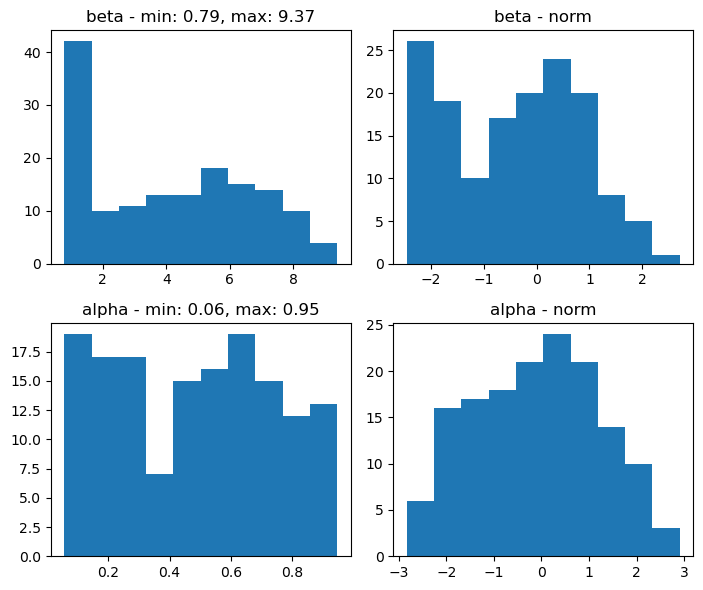

In [22]:
# plot 2 x 2
plt.figure(figsize=(7, 6))
plt.subplot(221)
plt.hist(params[:,0]);
plt.title(f'beta - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

plt.subplot(222)
plt.hist(beta2norm(params[:,0]));
plt.title(f'beta - norm');

plt.subplot(223)
plt.hist(params[:,1]);
plt.title(f'alpha - min: {min(params[:,1]):.2f}, max: {max(params[:,1]):.2f}');

plt.subplot(224)
plt.hist(alpha2norm(params[:,1]));
plt.title(f'alpha - norm');

plt.tight_layout()

In [23]:
ntrials, nblocks = 24, 6
print(f'ntrials: {ntrials}, nblocks: {nblocks}')

simulfunc = simul_dict['RW']
subj_dict = simulfunc(params, nblocks=nblocks, ntrials=ntrials)

ntrials: 24, nblocks: 6


100%|██████████| 150/150 [00:01<00:00, 78.56it/s]


In [24]:
print(subj_dict.keys())

dict_keys(['params', 'ev', 'ch_prob', 'choices', 'choices_A', 'rewards', 'pe', 'choice_nll'])


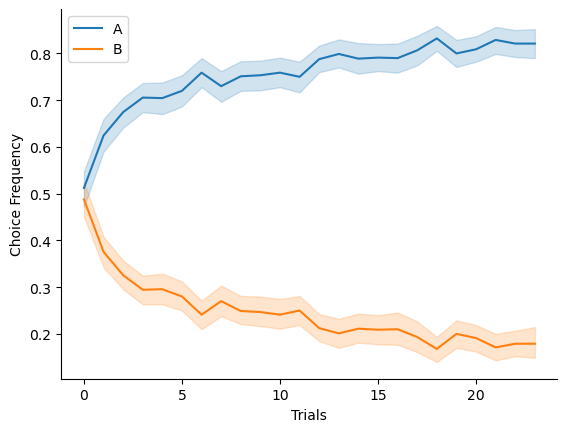

In [25]:
plotting.plot_choices(subj_dict['choices_A']) 

In [26]:
# create a list of lists with choices and rewards for each subject
all_data = []
for idx, (choices, rewards) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'])):
    all_data += [[choices, rewards]]

In [29]:
# Instantiate and fit the model
model = HierarchicalEMModel(objfunc=rw_models.fit, param_names=param_names)

results = model.EMfit(all_data)

11133.846 (000), 9771.251 (001), 9701.084 (002), 9684.308 (003), 9678.658 (004), 9676.163 (005), 9674.894 (006), 9674.020 (007), 9673.555 (008), 9673.265 (009), 9673.159 (010), 9672.993 (011), 9672.885 (012), 9672.762 (013), 9672.688 (014), 9672.769 (015), 9672.668 (016), 9672.673 (017), 9672.616 (018), 9672.671 (019), 9672.772 (020), 9672.708 (021), 9672.652 (022), 9672.687 (023), 9672.720 (024), 9672.671 (025), 9672.716 (026), 9672.678 (027), 9672.701 (028), 9672.745 (029), 9672.708 (030), 9672.753 (031), 9672.747 (032), 9672.786 (033), 9672.819 (034), 9672.684 (035), 9672.696 (036), 9672.690 (037), 9672.752 (038), 9672.721 (039), 9672.721 (040),  -- CONVERGED!!!!!


In [34]:
m, inv_h, posterior, NPL, convergence = results.values()

In [40]:
## Now store all relevant outputs in modout dict and save it
save_fit = False

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')
modout[modelID]['behavior'] = subj_dict  # copy behavior here

# Fill in fit information
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
        if 'beta' in param_name:
            est_params[subj_idx, param_idx] = norm2beta(m[param_idx, subj_idx])
        elif 'lr' in param_name:
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood

# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['ev']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modout[modelID]['fit']['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modout[modelID]['fit']['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modout[modelID]['fit']['choices_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['pe']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['negll']       = np.zeros((nsubjects,))

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
Laplace_approx, lme, goodHessian = calc_LME(inv_h, NPL)
modout[modelID]['fit']['Laplace_approx'] = Laplace_approx
modout[modelID]['fit']['lme'] = lme
modout[modelID]['fit']['goodHessian'] = goodHessian
for subj_idx in range(nsubjects):
    # Get subjectwise model predictions# get info for current subject
    choices = subj_dict['choices'][subj_idx,:,:]
    rewards = subj_dict['rewards'][subj_idx,:,:]
    
    model_fits = rw_models.fit(m[:,subj_idx], choices, rewards, prior=None, output='all')

    # store model fits
    modout[modelID]['fit']['ev'][subj_idx,:,:,:] = model_fits['ev']
    modout[modelID]['fit']['ch_prob'][subj_idx,:,:,:] = model_fits['ch_prob']
    modout[modelID]['fit']['choices'][subj_idx,:,:] = model_fits['choices']
    modout[modelID]['fit']['choices_A'][subj_idx,:,:] = model_fits['choices_A']
    modout[modelID]['fit']['rewards'][subj_idx,:,:] = model_fits['rewards']
    modout[modelID]['fit']['pe'][subj_idx,:,:] = model_fits['pe']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']

# Save output
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modout, f)

Good Hessians: 150 out of 150


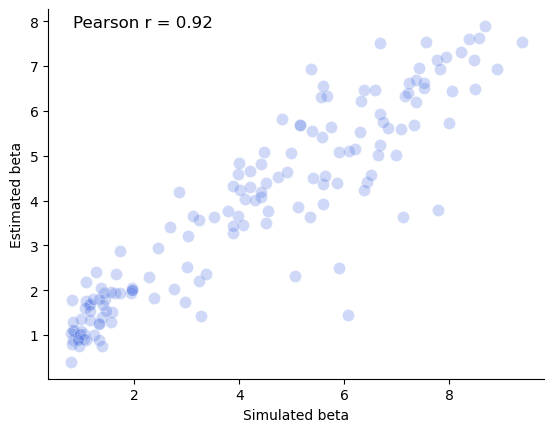

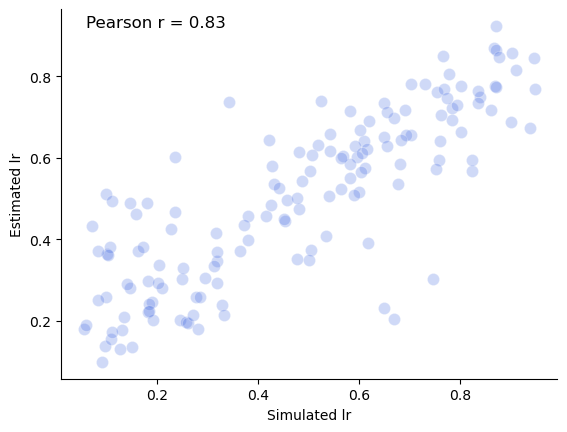

In [36]:
for param_idx, param_label in enumerate(['beta', 'lr']):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = est_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

In [37]:
modout[modelID]['fit']['BICint'] = calc_BICint(all_data, param_names, posterior['mu'], posterior['sigma'], rw_models.fit)

In [38]:
print(modout[modelID]['fit']['BICint'])

19297.624605284753


In [39]:
bic2= calc_BICint(all_data, param_names, posterior['mu'], posterior['sigma'], rw_models.fit)

print(bic2)

19296.728133086835
